<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Time_series_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series data analysis using Deep Learning

In this notebook, we'll analyze stock prices of a company with the aim of predicting stock prices based on historical prices.

The stock price levels have a structure that we want to exploit. Time-series is usually modeled in a recursive way, typically using auto-regressive models, which are linear models that don't consider non-linearity in the data.

In particular, we illustrate the use of two deep learning techniques for analyzing time-series data - Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) to analyze historical stock prices of a company and use the trained model to predict stock prices. The main goal is to learn how to use these tools for time-series prediction.

Let's start by installing or importing required Python packages. We'll use Yahoo Finance to download stock prices and Tensorflow to implement MLP and CNN.

In [1]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import gc
import os
import random
import copy
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

from pyts.image import GramianAngularField

We'll analyze the closing price of Apple (AAPL) stocks. Let's collect data from past 2000 trading days and visualize the raw data.

[*********************100%%**********************]  1 of 1 completed


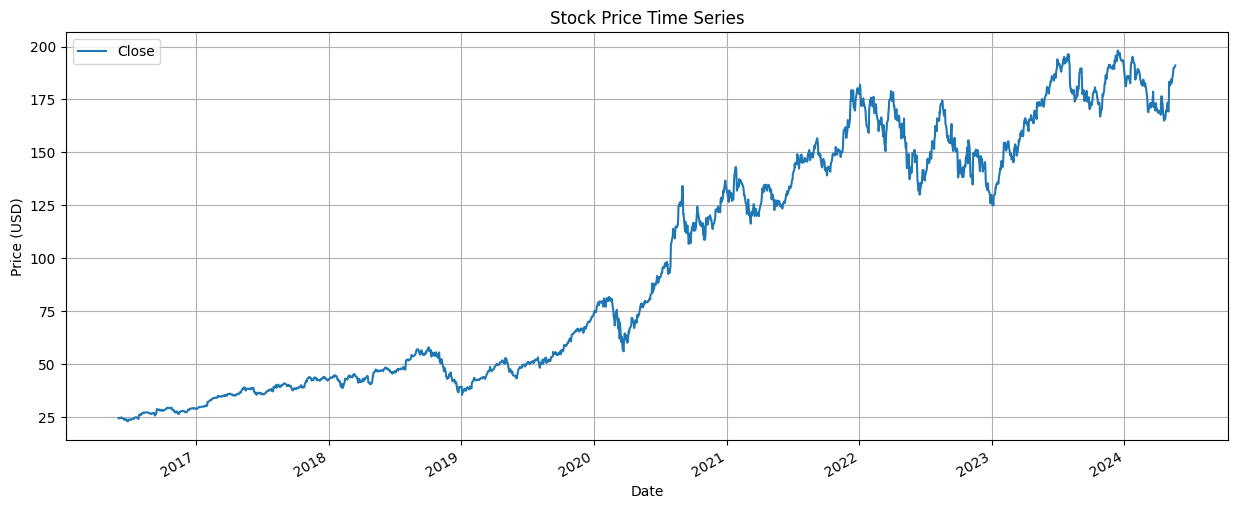

In [3]:
# Load stock price data
df = yf.download("AAPL", start="2016-06-01", end="2024-05-21")
df=df.drop(columns=['Open','High','Low','Volume', 'Adj Close'])

# Plot the original time series
df.plot(figsize=(15,6))
plt.title('Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

Let's check the summary statistics.

In [4]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
             Close
count  2006.000000
mean     98.450604
std      56.856812
min      23.010000
25%      43.598126
50%      80.936249
75%     150.799999
max     198.110001


Usually univariate time series analysis is done on a stationary series, so first off we'll check for stationarity. To check stationarity visually, we plot ACF and PACF for different lags. The blue shaded region shows the confidence intervals.

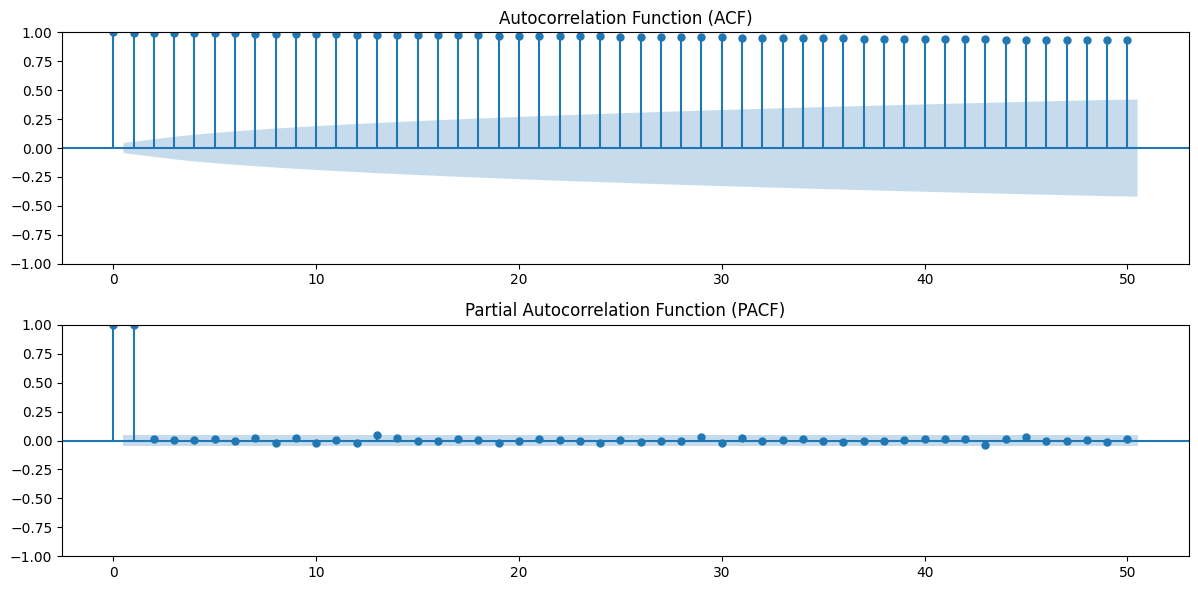

In [5]:
# ACF and PACF plots for persistence

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df, ax=plt.gca(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(2, 1, 2)
plot_pacf(df, ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

It is evident from the plot that the time-series is non-stationary. We can conclude this because the lags of the ACF are significant.

After visual inspection, let us try to confirm our conclusion using hypothesis testing method - ADF test, to test for stationarity.

In [6]:
# Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(df)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")


ADF Test Results:
ADF Statistic: -0.4605141594598856
p-value: 0.8994943104821944
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


The ADF statistic is larger than the critical values at different level of significance. We cannot reject the null hypothesis of non-stationarity.

Let's use the logarithm of the original series to see if transformed series is stationary.

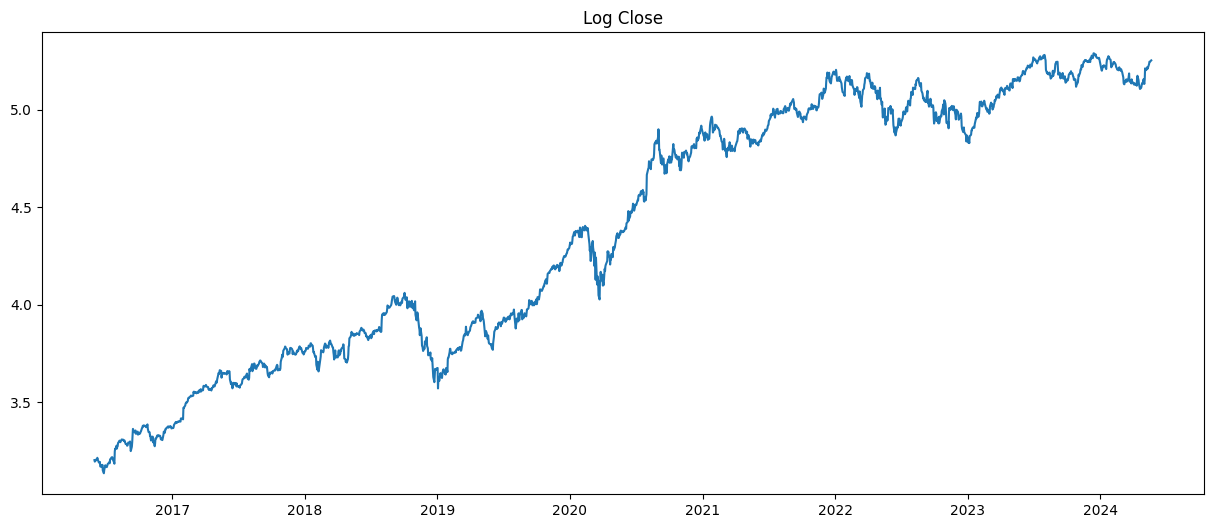

In [7]:
df_log = pd.DataFrame(np.log(df['Close']),index=df.index)
plt.figure(figsize=(15,6))
plt.plot(df_log)
plt.title('Log Close')
plt.show()

In [8]:
# Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(df_log)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")


ADF Test Results:
ADF Statistic: -1.2776245051912318
p-value: 0.6393459548923692
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


The log of the series is also non-stationary. Some common techniques to make time series data stationary:


* **Differencing**: Take the difference between consecutive observations.
* **Transformation**: Apply transformations such as logarithmic transformation
* **Fractional Differencing**: Partially doing differencing to achieve stationarity



##Differencing

Let's now try to difference the series or the log of the series.

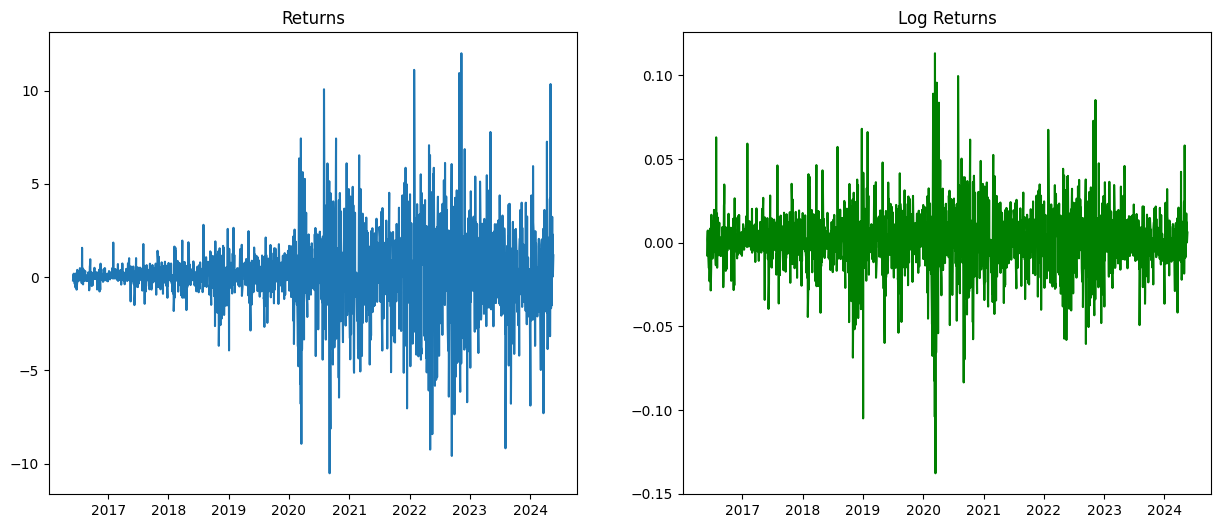

In [9]:
df['Returns']=df['Close']-df['Close'].shift(1)
df_log['Log_Returns']=df_log['Close']-df_log['Close'].shift(1)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df['Returns'])
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(df_log['Log_Returns'],'g-')
plt.title('Log Returns')
plt.show()

Let's check both of our new series through the ADF test.

In [10]:
adf_result_returns = adfuller(df['Returns'].dropna())
print("\nADF Test Results for Returns:")
print("ADF Statistic:", adf_result_returns[0])
print("p-value:", adf_result_returns[1])
print("Critical Values:")
for key, value in adf_result_returns[4].items():
    print(f"\t{key}: {value}")


adf_result_log_returns = adfuller(df_log['Log_Returns'].dropna())
print("\nADF Test Results for Log_Returns:")
print("ADF Statistic:", adf_result_log_returns[0])
print("p-value:", adf_result_log_returns[1])
print("Critical Values:")
for key, value in adf_result_log_returns[4].items():
    print(f"\t{key}: {value}")


ADF Test Results for Returns:
ADF Statistic: -14.606628895391774
p-value: 4.084929825598094e-27
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156

ADF Test Results for Log_Returns:
ADF Statistic: -14.068038529279898
p-value: 2.974401974504954e-26
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


We have stationary series that we can now work with for our forecasts.

##Fractional Differencing
Next, let's use an approach called fractional differencing. Using fractionally differenced variables as dependent variables or features for time series modelling could improve predictive performance in many cases because the time series is allowed to retain more memory while still being stationary.

In [11]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1)
    return w
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()
def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients

    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [12]:
df['Fractional'] = ts_differencing(df['Close'],0.9,20)
df_log['Fractional'] = ts_differencing(df_log['Close'],0.9,20)

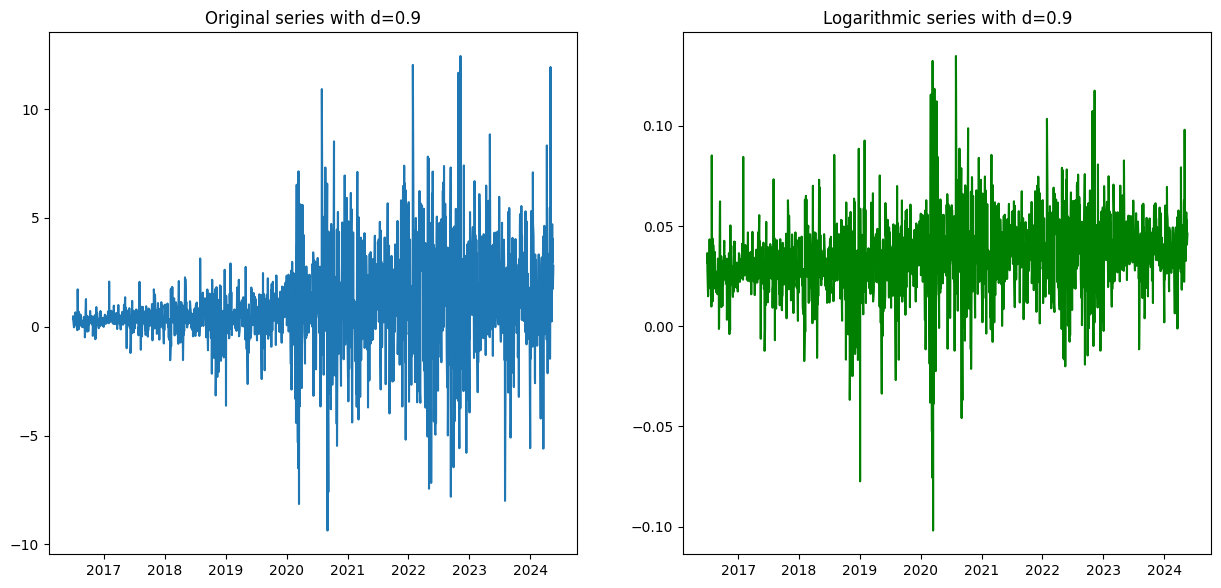

In [13]:
differences=[0.9]
fig, axs = plt.subplots(len(differences),2,figsize=(15,6))
for i in range(0,len(differences)):
    axs[0].plot(df['Fractional'])
    axs[0].set_title('Original series with d='+str(differences[i]))
    axs[1].plot(df_log['Fractional'],'g-')
    axs[1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.01) #increasing space between plots for aestethics

Let's check both of our new series through the ADF test.

In [14]:
adf_result_fractional = adfuller(df['Fractional'].dropna())
print("\nADF Test Results for Fractional:")
print("ADF Statistic:", adf_result_fractional[0])
print("p-value:", adf_result_fractional[1])
print("Critical Values:")
for key, value in adf_result_fractional[4].items():
    print(f"\t{key}: {value}")


adf_result_log_fractional = adfuller(df_log['Fractional'].dropna())
print("\nADF Test Results for Fractional:")
print("ADF Statistic:", adf_result_log_fractional[0])
print("p-value:", adf_result_log_fractional[1])
print("Critical Values:")
for key, value in adf_result_log_fractional[4].items():
    print(f"\t{key}: {value}")


ADF Test Results for Fractional:
ADF Statistic: -7.401482908989515
p-value: 7.534908468166931e-11
Critical Values:
	1%: -3.4336771595431106
	5%: -2.863009746829746
	10%: -2.5675524325901415

ADF Test Results for Fractional:
ADF Statistic: -6.328209788530858
p-value: 2.9503178659131254e-08
Critical Values:
	1%: -3.4336788532475775
	5%: -2.8630104945933974
	10%: -2.567552830738709


After fractional differencing, the series is stationary.

The data frame contains three series - the closing price, the daily returns and the fractional differences. Each of the three series will be used for forecasting individually.

In [15]:
df.tail()

,Close,Returns,Fractional
Date,,,
2024-05-14,187.429993,1.149994,2.954432
2024-05-15,189.720001,2.290009,4.046171
2024-05-16,189.839996,0.119995,1.981708
2024-05-17,189.869995,0.029999,1.736780
2024-05-20,191.039993,1.169998,2.794917


##Multi-Layer Perceptron model (MLP or Artificial Neural Network)

In [16]:
def train_test_data(target_variable):
  """
  Return the training and testing data for the target variable. The target variable
  is one of the series - Closing price, daily returns or fractional differences.
  The data is split into 80% training and 20% testing based on time. The first 80%
  of the data is used for training and the last 20% for testing.
  """
  df_copy = df.loc[:,df.columns.isin([target_variable])]

  # Creating input features by shifting the target variable
  look_back = 5  # Number of past time steps to consider
  for i in range(1, look_back+1):
    df_copy[f'lag_{i}'] = df_copy[target_variable].shift(i)

  df_copy.dropna(inplace=True)

  scaler = MinMaxScaler()
  df_copy[df_copy.columns] = scaler.fit_transform(df_copy[df_copy.columns])

  X = df_copy.iloc[:, 1:].values  # Input features
  y = df_copy[target_variable].values  # Target variable

  # Calculate the index to split the data
  split_index = int(len(df_copy) * 0.8)  # Use 80% of the data for training

  # Split the data into training and testing sets
  train_data = df_copy.iloc[:split_index]
  test_data = df_copy.iloc[split_index:]
  return train_data, test_data

In [17]:
def mlp(target_variable, train_data, test_data):
  """
  Method to train, test and plot the results of a Multi-Layer Perceptron (MLP) model
  for predicting the target variable.
  """
  # Extract input features and target variable for training and testing sets
  X_train = train_data.iloc[:, 1:].values
  y_train = train_data[target_variable].values
  X_test = test_data.iloc[:, 1:].values
  y_test = test_data[target_variable].values

  hp_lr = 1e-5  # Learning rate
  adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
  model = get_mlp_model(X_train)
  es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
  )
  model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

  model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[es])

  loss, mae = model.evaluate(X_test, y_test)
  print("Test Loss:", loss)
  print("Test MAE:", mae)

  predictions = model.predict(X_test)

  plt.figure(figsize=(20, 6))
  plt.plot(y_test, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Actual vs. Predicted Values ({target_variable})')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

Let's define a MLP model that we'll train on historical stock prices.

In [18]:
def get_mlp_model(X_train):
  """
  Method to define a MLP model for predicting the target variable.
  The model consists of a input layer, a dense hidden layer with 64 neurons, a dropout layer,
  and a dense output layer.
  """
  mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer with 1 neuron for regression
  ])
  mlp_model.summary()
  return mlp_model

###Predicting Price Levels

First, let's try out our model for forecasting the original price levels, the non-stationary data.

<ipython-input-16-cf3de32cada9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[f'lag_{i}'] = df_copy[target_variable].shift(i)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
40/40 [===

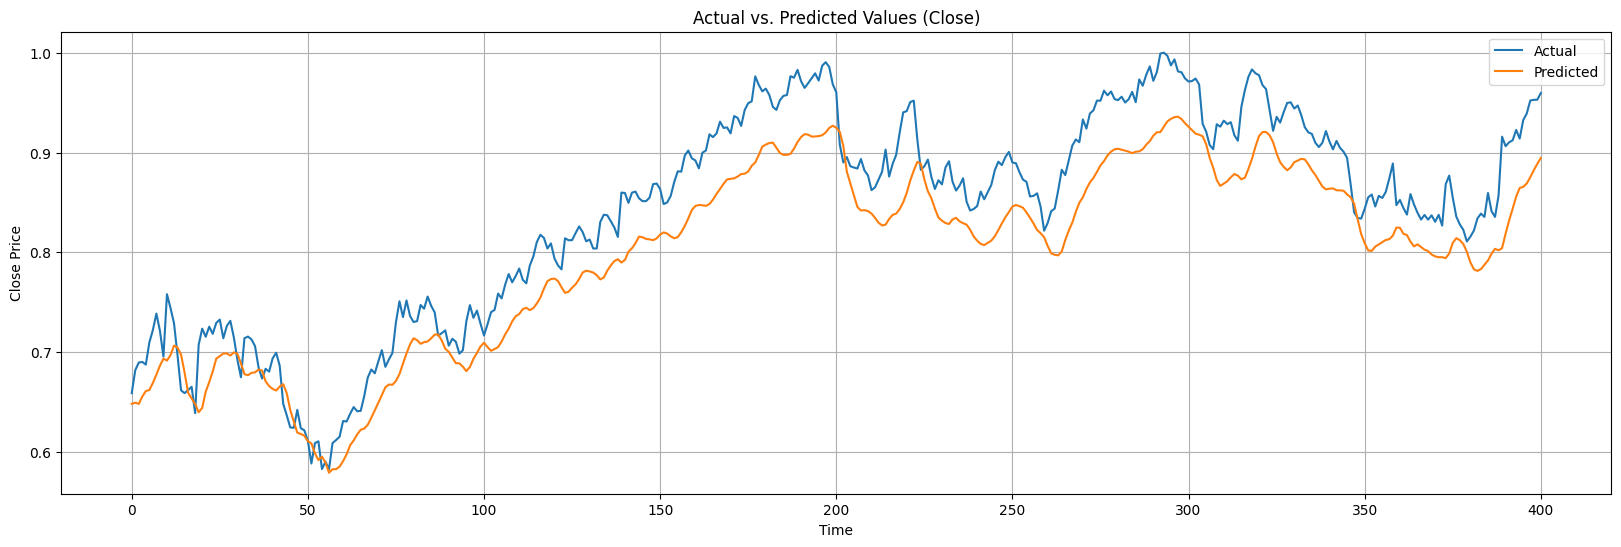

In [19]:
target_variable = 'Close'
train_data, test_data = train_test_data(target_variable)
mlp(target_variable, train_data, test_data)

###Predicting Returns
Next, let us try the model on the daily returns data which is stationary.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                384       
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-65-cf3de32cada9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[f'lag_{i}'] = df_copy[target_variable].shift(i)


Epoch 1/50
40/40 [==============================] - 3s 35ms/step - loss: 0.2533 - mae: 0.4902 - val_loss: 0.2334 - val_mae: 0.4648
Epoch 2/50
40/40 [==============================] - 0s 11ms/step - loss: 0.2312 - mae: 0.4674 - val_loss: 0.2174 - val_mae: 0.4473
Epoch 3/50
40/40 [==============================] - 0s 12ms/step - loss: 0.2208 - mae: 0.4558 - val_loss: 0.2019 - val_mae: 0.4296
Epoch 4/50
40/40 [==============================] - 0s 10ms/step - loss: 0.2015 - mae: 0.4340 - val_loss: 0.1873 - val_mae: 0.4122
Epoch 5/50
40/40 [==============================] - 0s 11ms/step - loss: 0.1893 - mae: 0.4198 - val_loss: 0.1735 - val_mae: 0.3952
Epoch 6/50
40/40 [==============================] - 0s 7ms/step - loss: 0.1807 - mae: 0.4088 - val_loss: 0.1604 - val_mae: 0.3784
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.1688 - mae: 0.3956 - val_loss: 0.1479 - val_mae: 0.3617
Epoch 8/50
40/40 [==============================] - 0s 6ms/step - loss: 0.1530 - mae:

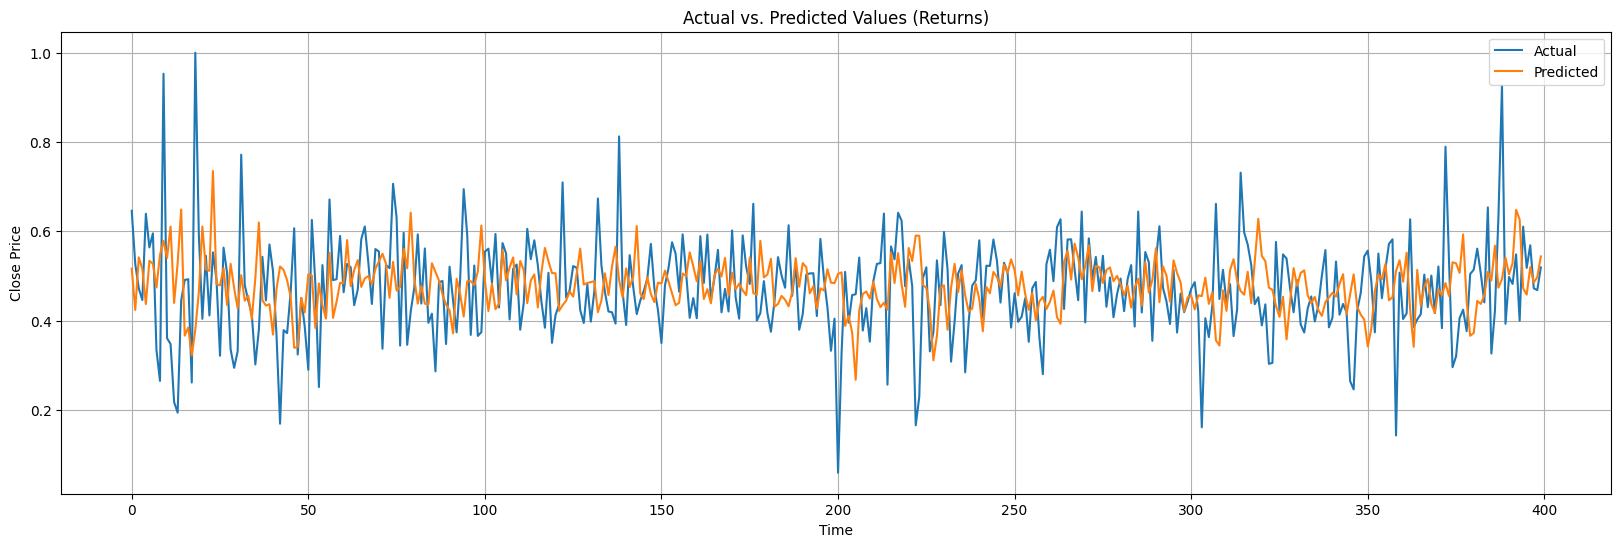

In [69]:
target_variable = 'Returns'
train_data, test_data = train_test_data(target_variable)
mlp(target_variable, train_data, test_data)

###Predicting Fractional differences
Finally, let's see if model does better on frational differences.

Model: "sequential_10"


<ipython-input-65-cf3de32cada9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[f'lag_{i}'] = df_copy[target_variable].shift(i)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                384       
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
40/40 [========================

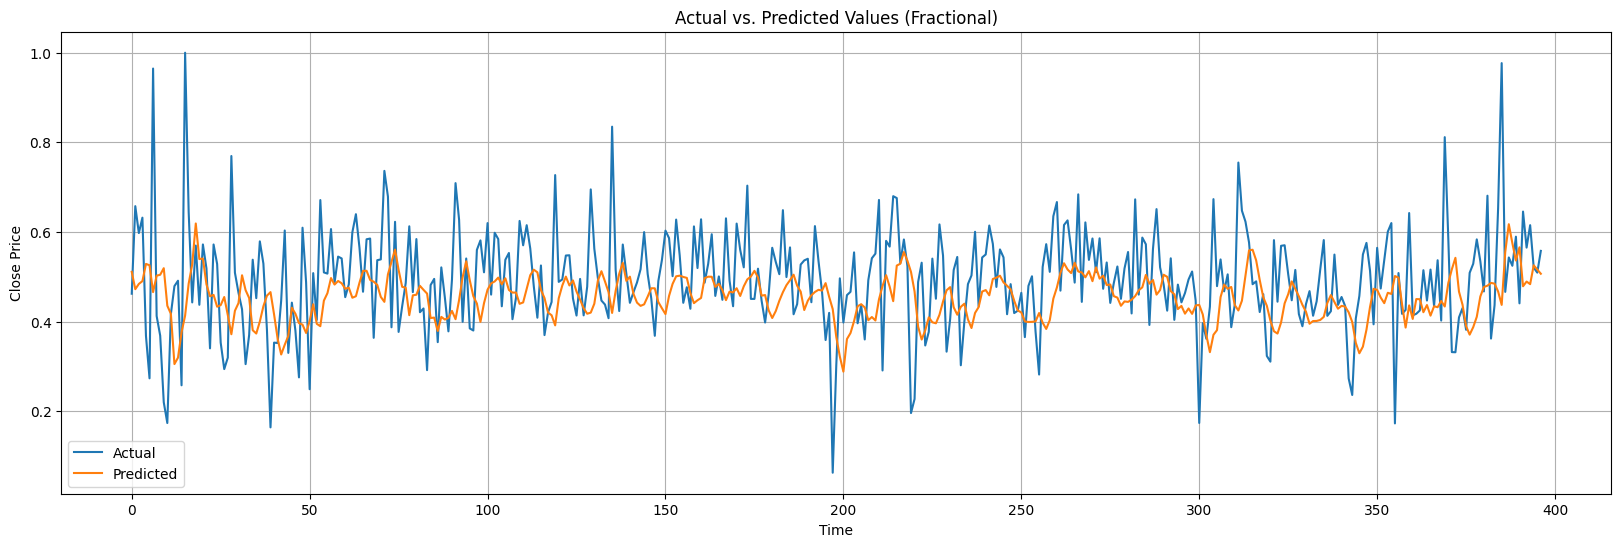

In [70]:
target_variable = 'Fractional'
train_data, test_data = train_test_data(target_variable)
mlp(target_variable, train_data, test_data)

Our evaluation of the models is based on the Mean absolute error on the test set, the loss is the mean squared error. As summarized below

- MLP from time series
    - Test Loss:  0.00138
    - Test MAE: 0.03088
- MLP from stationary time series (using differentiation)
    - Test Loss: 0.01418
    - Test MAE: 0.0882
- MLP from stationary time series (using partial differentiation)
    - Test Loss: 0.0164
    - Test MAE: 0.09767

In this case the model that perfomed best was the MLP from the time series, this indicates that the work done to obtain a stationary time series for autoregression might not be as important to Neural networks as it it is in the case of Autoregressive models like ARIMA or GARCH. While this is only shown for a fixed set of parameters here, however we saw the same behaviour across many different epochs and validation splits.  

##Convolutional Neural Network (CNN)

CNN are used for image analysis. The input to CNN are images. To convert the time-series data into images, we will use GAF (Gramian Angular Field) transformation on a window of 30 readings. The resulting images will be used to train the CNN.

In [71]:
def train_test_data_cnn(target_variable):
  """
  This method converts the time-series data into a series of images (30 x 30). These
  images are used to train CNN. The target variable here is the value of time-series
  at the window length.
  """
  Xdf = df.iloc[:,df.columns.get_loc(target_variable)]
  Xdf.dropna(inplace=True)
  X_train = []
  window_size = 30
  for i in range(window_size, Xdf.shape[0]):
    X_train.append(Xdf[i - window_size : i])
  X_train = np.array(X_train)
  #print(X_train.shape)
  # Define a "window_size"-days interval
  days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
  # Plot the overlapping time series
  #plt.figure(figsize=(6, 6))
  #for i in range(241):
  #  plt.plot(days[i : window_size + i], X_train[i, :])

  transformer = GramianAngularField()
  X_train_new = transformer.transform(X_train)
  #print(X_train_new.shape)

  # Show the results for the first time series
  #fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
  #ax[0].plot(X_train[0, :])
  #ax[1].imshow(X_train_new[0], cmap="rainbow")
  #print(X_train_new[0].shape)

  y_data = []
  for i in range(window_size, Xdf.shape[0] - window_size):
    y_data.append(Xdf[i])
  y_data = np.array(y_data)
  #y_data.shape

  X_data = X_train_new[:-window_size]
  for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
  # We could simply write X_data = (X_data + 1)/2
  X_data = X_data * 255

  # display several time series and the corresponding images
  #fig, ax = plt.subplots(2, 5, figsize=(20, 4))
  #for i in range(0, 125, 25):
  #  ax[0, int(i / 25)].plot(X_train[i])
  #for i in range(0, 125, 25):
  #  ax[1, int(i / 25)].imshow(X_data[i], "gray")

  # Split into train and test
  train_split = 0.8
  y_data_train = y_data[: int(train_split * y_data.shape[0])]
  y_data_test = y_data[int(train_split * y_data.shape[0]) :]
  X_data_train = X_data[: int(train_split * y_data.shape[0])]
  X_data_test = X_data[int(train_split * y_data.shape[0]) :]

  return X_data_train, X_data_test, y_data_train, y_data_test

In [72]:
def cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test):
  """
  Method to train, test and plot the results of a Convolutional Neural Network (CNN) model
  for predicting the target variable.
  """
  model = get_cnn_model()
  hp_lr = 1e-5  # Learning rate
  adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
  model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

  es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
  )

  model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[es],
  )
  loss, mae = model.evaluate(X_data_test, y_data_test)
  print("Test Loss:", loss)
  print("Test MAE:", mae)

  predictions = model.predict(X_data_test)

  plt.figure(figsize=(20, 6))
  plt.plot(y_data_test, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Actual vs. Predicted Values ({target_variable})')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

Let's define a deep learning model that we'll train on the data.

In [73]:
def get_cnn_model():
  """
  Method to define a CNN using Tensorflow.
  """
  cnn_model = tf.keras.Sequential()
  # Input layer
  cnn_model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
  cnn_model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
  cnn_model.add(tf.keras.layers.MaxPooling2D(2))
  cnn_model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
  cnn_model.add(tf.keras.layers.MaxPooling2D(2))
  cnn_model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
  cnn_model.add(tf.keras.layers.MaxPooling2D(2))
  cnn_model.add(tf.keras.layers.Flatten())
  cnn_model.add(tf.keras.layers.Dense(1024, activation="relu"))
  cnn_model.add(tf.keras.layers.Dropout(0.5, seed=1234))
  cnn_model.add(tf.keras.layers.Dense(1))
  cnn_model.summary()
  return cnn_model

###Predicting Price Levels

Using GAF representation of the closing price levels, let us do the forecasting.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 2, 2, 64)        

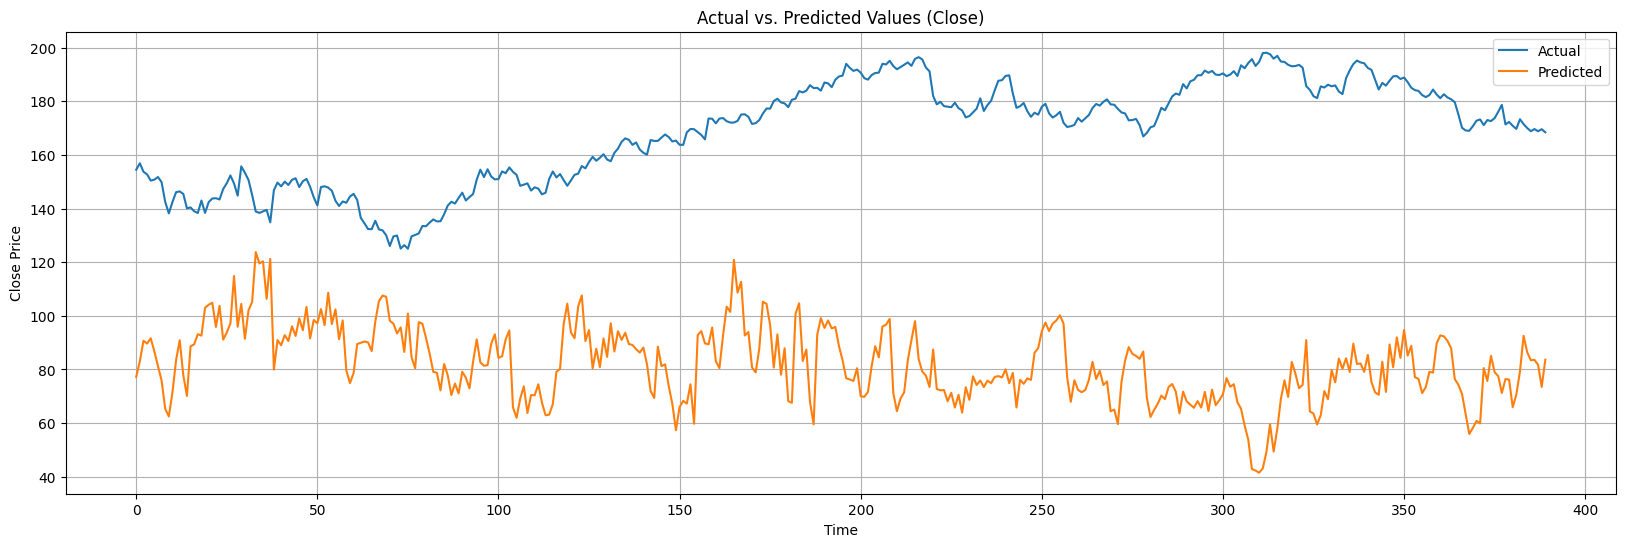

In [74]:
target_variable = 'Close'
X_data_train, X_data_test, y_data_train, y_data_test = train_test_data_cnn(target_variable)
cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test)

###Predicting Returns

Using GAF representation of the daily returns, let us do the forecasting.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 2, 2, 64)        

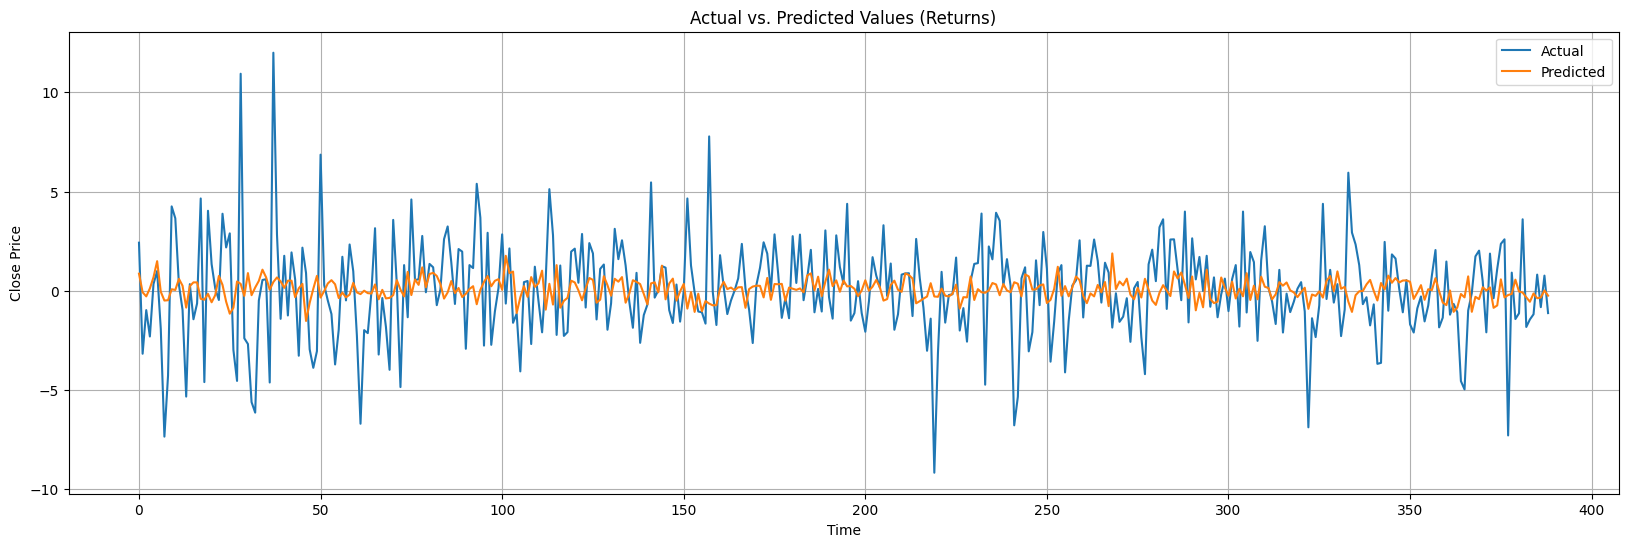

In [75]:
target_variable = 'Returns'
X_data_train, X_data_test, y_data_train, y_data_test = train_test_data_cnn(target_variable)
cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test)

###Predicting Fractional differences

Using GAF representation of the fractionally-differenced time series, let us do the forecasting.

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 2, 2, 64)        

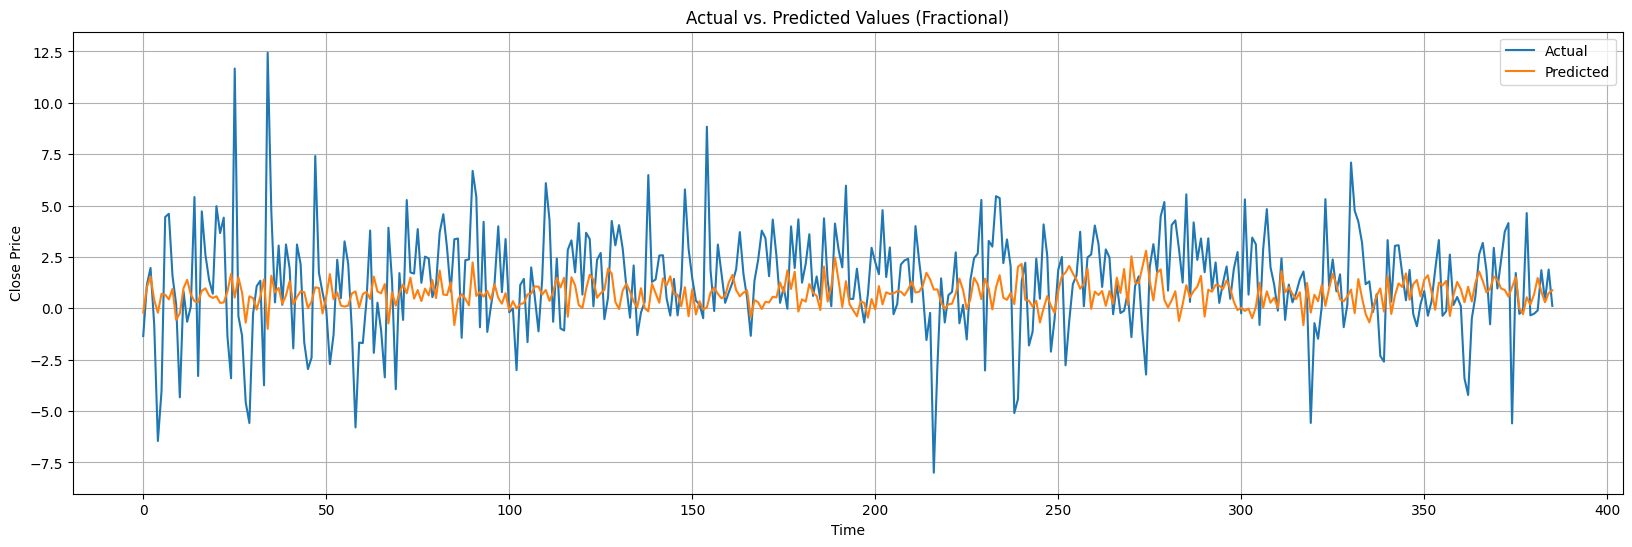

In [76]:
target_variable = 'Fractional'
X_data_train, X_data_test, y_data_train, y_data_test = train_test_data_cnn(target_variable)
cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test)

Our evaluation of the models is based on the Mean absolute error on the test set, the loss is the mean squared error. As summarized below

- MLP from time series
    - Test Loss:  0.1447
    - Test MAE: 0.31504
- MLP from stationary time series (using differentiation)
    - Test Loss: 0.02199
    - Test MAE: 0.1176
- MLP from stationary time series (using partial differentiation)
    - Test Loss:  0.0185
    - Test MAE:  0.10489

In this representation the Convolution neural networks do better, the best performance was obtained with the data that was partially differentiated, The model does not seem to do too good on the test set, this might be due to the newtwork not being complex enough or the architecture of the CNN might be too simple for the comple structure of the time series.

While the metrics used indicate that using a neural network on time series might be a better approach than translating the time series into an image to train a CNN.